#### Importar lo necesario

In [ ]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt


#### configuramos el `device` acorde al device disponible




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


#**MNIST data base**
# Ejemplo de red neuronal de convolución (CNN)

Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.
7. Visualizar el kernel.
8. Visualizar las activaciones.
9.  Ejercicio nro 1.




## 1. Cargar base de datos

In [ ]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#<---------------- esto es GLORIOSO!!
                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(), #<------------------- esto es GLORIOSO!!
                        #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## 2. Ver que la base de datos esté OK

In [ ]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


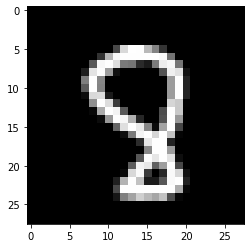

Label: 8


In [ ]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[0]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[0]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 3. Construyo mi CNN

In [ ]:
# defino primero un "bloque" de una capa CNN
# construido con los bloques funcionales vistos en clase
#
# (hiper)parámetros a pasar a la función:
#   c_in:   canales (kernels) de entrada
#   c_out:  canales (kernels) de salida
#   k:      tamaño del kernel kxk
#   p:      tamaño del padding de la convolución
#   s:      stride de la convolución
#   pk:     tamaño del kernel del pooling
#   ps:     stride de la pooling
#   pp:     padding en la pooling
#
#   la función pooling se elige directamente dentro del bloque!

def block(c_in, c_out, k=3, p=1, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.ReLU(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


# ahora SI construyo mi red... usando la clase CNN de pytorch
# revisar muy bien las dimensiones a emplear en cada capa y
# tener presente la reducción de las dimensiones.
#
# en la útlima capa fully conected 'fc', hacer bien el cálculo final del
# tamaño del array que se obtiene siguiendo la formula vista en la teoria
# tanto para la capa conv como para la capa pooling.
#
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv1_out = None
    self.conv2 = block(64, 128)
    self.conv2_out = None
    #self.conv3 = block(128, 128)
    #self.conv3_out = None
    #self.conv4 = block(128, 128)
    #self.conv4_out = None
    self.fc = torch.nn.Linear(128*7*7, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion forward que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    #x = self.conv3(x)
    #print("Tamaño salida conv3: ", x.shape)

    #x = self.conv4(x)
    #print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    #self.conv3_out = self.conv3(self.conv2_out)
    #self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv2_out.view(self.conv2_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [ ]:
model = CNN()


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  3
Número total de parámetros a entrenar:  137226


## 4. Veamos que las dimensiones sean consistentes.

In [ ]:
model.validar_dim()

Validacion de dimensiones
Ingrese tamaño de entrada: 28
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 64, 14, 14])
Tamaño salida conv2:  torch.Size([1, 128, 7, 7])
Tamaño imagen vectorizada:  torch.Size([1, 6272])
Tamaño salida fc (nro clases):  torch.Size([1, 10])


## 5. Armo las funciones necesarias

In [ ]:
from tqdm import tqdm # <- para graficar la barra de avance


def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        

## 6. Entreno la red

In [ ]:
fit(model, dataloader)

val_loss 0.12686 val_acc 0.96218: 100%|██████████| 157/157 [00:01<00:00, 78.60it/s]


Epoch 1/5 loss 0.42359 val_loss 0.12686 acc 0.88363 val_acc 0.96218


val_loss 0.06908 val_acc 0.97910: 100%|██████████| 157/157 [00:02<00:00, 68.49it/s]


Epoch 2/5 loss 0.10357 val_loss 0.06908 acc 0.96927 val_acc 0.97910


val_loss 0.05241 val_acc 0.98298: 100%|██████████| 157/157 [00:01<00:00, 88.57it/s]


Epoch 3/5 loss 0.07211 val_loss 0.05241 acc 0.97796 val_acc 0.98298


val_loss 0.04357 val_acc 0.98676: 100%|██████████| 157/157 [00:01<00:00, 89.64it/s]


Epoch 4/5 loss 0.05908 val_loss 0.04357 acc 0.98213 val_acc 0.98676


val_loss 0.04109 val_acc 0.98637: 100%|██████████| 157/157 [00:01<00:00, 90.30it/s]

Epoch 5/5 loss 0.04996 val_loss 0.04109 acc 0.98467 val_acc 0.98637


## 7. Vemos que funcione.

torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


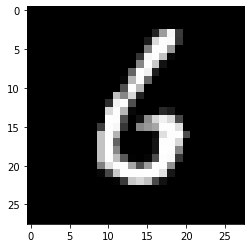

torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[ -1.5562,  -6.3763,  -5.5817,  -5.7976,  -3.8698,  -0.5974,   8.7681,
         -10.9279,  -4.4006, -11.9227]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
softmax de predicción:
tensor([[3.2822e-05, 2.6476e-07, 5.8601e-07, 4.7226e-07, 3.2465e-06, 8.5624e-05,
         9.9987e-01, 2.7932e-09, 1.9094e-06, 1.0329e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
El numero es un:  6


In [ ]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 50

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))
# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print(samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat)
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1))
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())


## 8. Visualizar el kernel

In [ ]:
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)

In [ ]:
model.conv1

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [ ]:
model.conv1[0]

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
model.conv1[0].weight.shape

torch.Size([64, 1, 3, 3])

In [ ]:
# fuente: https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    grid = grid.to("cpu")
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

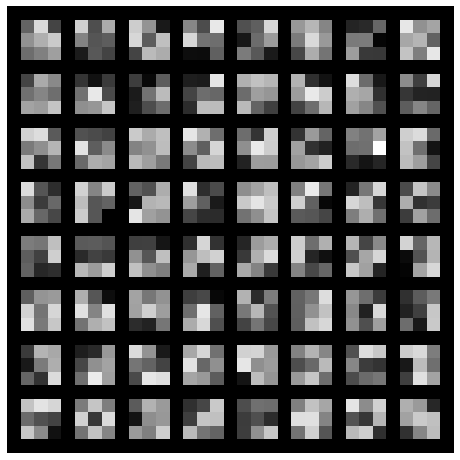

In [ ]:
filter = model.conv1[0].weight.data.clone()

visTensor(filter, ch=0, allkernels=True)

plt.axis('off')
plt.ioff()
plt.show()

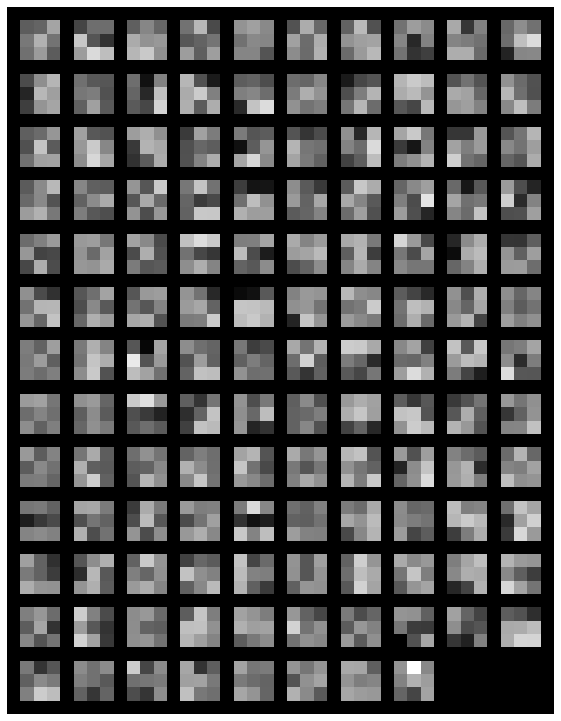

In [ ]:
filter = model.conv2[0].weight.data.clone()
filter.shape
visTensor(filter, ch=0, allkernels=False, nrow=10)

plt.axis('off')
plt.ioff()
plt.show()

## 9. Visualizar las "salidas" o "activaciones"

In [ ]:
model.conv1_out.shape

torch.Size([1, 64, 14, 14])

In [ ]:
a = model.conv1_out.squeeze().to("cpu").detach()
a.shape

torch.Size([64, 14, 14])

In [ ]:
a[0].detach()

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1031, 0.5048,
         0.5048, 0.0544, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3917, 0.7086,
         0.6353, 0.0753, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2137, 0.5894, 0.7086,
         0.5334, 0.0066, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4704, 0.5894, 0.5894,
         0.2194, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3590, 0.4886, 0.4886, 0.3376,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2972, 0.7173, 0.7173, 0.3778, 0.1347,
         0.1327, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2972, 0.7316, 0.6287, 0.3959, 0.7895,
  

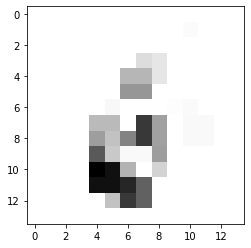

In [ ]:
from matplotlib import cm
plt.imshow(a[4].numpy()*255, cmap=cm.gray_r)
plt.show()




## 10. EJERCICIO NRO 1

## Probemos con un número nuestro!
Primero lo dibujamos en el paint con un tamaño próximo a 28x28 pixeles
(el tamaño del papel puede ser aproximado)...
Después haremos un `resize`.
Usar un marcador grueso que pinte varios pixeles!!!!

Cargamos el archivo hecho a mano

In [ ]:
from google.colab import files
files.upload()

Saving cero.png to cero.png


{'cero.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00+\x00\x00\x00-\x08\x02\x00\x00\x00\xb8f\x05\x8a\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc3\x00\x00\x0e\xc3\x01\xc7o\xa8d\x00\x00\x00\xf9IDATXG\xed\x96Q\x0e\xc20\x0cC)\xf7\xbfs\xe94T\xa1\xb2\xd5/f\xd3\x00e\xdf\xa9\xf3\xea$kJ\xad\xf5v\xe9w\xbf4\xfb\x92<\t\xbe\xc1\x83\x02;\xb1\x942\xef\x18\xa8\xf3.\x82\x08d\xfa\xaekp\x04\x08\xe6\xea\x9d2\nq\xd8,\xf4\xc4\xdc\xb0\xd59M\xc0\x15_!\xf8)A\x10\xf5\xb6A\x9cR\x85\xa8\xe8j/\xb4AW\xc1\xf8m\x87zbF\x00/\xb1\x89\xc8m\xd3\x1ep-\xc3-4\x0b\x9e.?\xa5=\xe0Z^d\x12\x90\x7f\xa2\xe7-?\x95U\xc8*\xb0\xd7\x99\xf7\x94\x17\xa9;\xf1\x93\xd7\x810\xcd\x08BO\x1cI\xb6\x19#<\xb0\x9f%\xee\x9c\xaeBh\xdd\x18nI.\xa0\t\xa2\xb5h\xb7\xe7\x06,\xab\x14\xc1\x1cV\xae\xbd#Cb\xaa\x0c\xe3\xf8\xde\xd7"\xb9f\xc0\x83^\xe0\xb9\xc3\xa1\xdc\xcf\x0e3\xce\xd8\x83\xe7L\xe3\xb1\xc9\x92`\xc7O\xfd?8\xbb\x10I\x90;\xd2\xaf\xecH\xff?\x0b\x0f[\xf0WAUTGT\x00\x00\

In [ ]:
# desde colab
#from google.colab import drive
#drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# lo leemos
num_ex = torchvision.io.read_image('cero.png')
#num_ex= torchvision.io.read_image('/content/drive/My Drive/CIA_marcos/deep_learning/clase_5/tres.png')

Veamos el tamaño, datatype, etc.

In [ ]:
print(num_ex.shape)
print(num_ex.dtype)
num_ex = num_ex.float()
print(num_ex.dtype)
print(num_ex[0][0][0])

torch.Size([3, 45, 43])
torch.uint8
torch.float32
tensor(255.)


Apliquemos algunas transformaciones para llevarlo al tamaño deseado

In [ ]:
num_ex_2 = torchvision.transforms.Resize(size=(28,28))(num_ex)
print(num_ex_2.shape)

torch.Size([3, 28, 28])


Tamaño de la imagen cargada
torch.Size([1, 28, 28])
vermos valor luego de "normalizar"
pixel [0,0]:  tensor(0.9999)


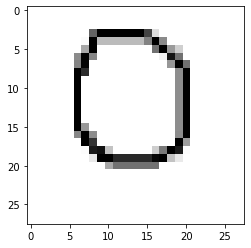

Y ahora lo invertimos


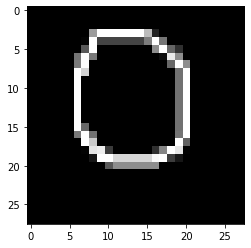

pixel [0,0]:  tensor(9.9957e-05)


In [ ]:
# lo pasamos a greyscale
num_ex_3 = torchvision.transforms.Grayscale(num_output_channels=1)(num_ex_2)
print('Tamaño de la imagen cargada')
print(num_ex_3.shape)
# lo normalizamos a 1
num_ex_4 = torchvision.transforms.Normalize((0,), (255,))(num_ex_3)
print('vermos valor luego de "normalizar"')
print('pixel [0,0]: ', num_ex_4[0][0][0])
# lo vemos
plt.imshow(num_ex_4.squeeze(), cmap='gray')
plt.show()
# lo invertimos (fonde negro, letra blanca)
print('Y ahora lo invertimos')
num_ex_5 = torchvision.transforms.functional.invert(num_ex_4)
plt.imshow(num_ex_5.squeeze(), cmap='gray')
plt.show()
print('pixel [0,0]: ', num_ex_5[0][0][0])

Podemos colocar todas las transformaciones juntas con `.transforms.Compose`

In [ ]:
adaptacion = torchvision.transforms.Compose([
                                             torchvision.transforms.Resize(size=(28,28)),
                                             torchvision.transforms.Grayscale(num_output_channels=1), #<---------- IMPORTANTE!
                                             torchvision.transforms.Normalize((0,), (255,)),
                                             #torchvision.transforms.Normalize((0.1307,), (0.3081,)), #<---------- IMPORTANTE!
                                            ])

In [ ]:
num_ex_adap = adaptacion(num_ex)
print(num_ex_adap.shape)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)

print('pixel [0,0]: ',num_ex_adap[0][0][0])
print('pixel maximo: ', torch.max(num_ex_adap))
print('pixel minimo: ', torch.min(num_ex_adap))

torch.Size([1, 28, 28])
pixel [0,0]:  tensor(9.9957e-05)
pixel maximo:  tensor(1.)
pixel minimo:  tensor(9.9838e-05)


Veamos como quedó

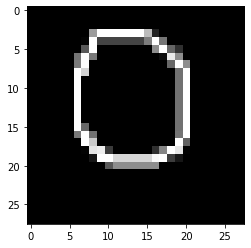

In [ ]:
plt.imshow(num_ex_adap.squeeze(), cmap='gray')
plt.show()

Lo pasamos por la red...
RECORDAR ENVIARLO A `DEVICE`

In [ ]:
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).to(device)
print('entrada:   ',num_ex_adap_batch.shape)

model.to(device)
y_hat = model(num_ex_adap_batch)
print('Salida red:  ')
print(y_hat)
print('Salida softmax(salida red):')
print(torch.nn.functional.softmax(y_hat, dim=1))
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

entrada:    torch.Size([1, 1, 28, 28])
Salida red:  
tensor([[  1.5110, -12.4227,  -2.2485,  -6.9477,  -7.6525,  -8.5274,  -4.4287,
          -8.1691,  -7.1130,  -1.4423]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Salida softmax(salida red):
tensor([[9.2704e-01, 8.2367e-07, 2.1596e-02, 1.9658e-04, 9.7149e-05, 4.0503e-05,
         2.4406e-03, 5.7952e-05, 1.6663e-04, 4.8360e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
El numero es un:  0
